In [3]:
%matplotlib inline
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING
from vnpy.trader.app.ctaStrategy.ctaTemplate import CtaTemplate, BarManager
from vnpy.trader.app.ctaStrategy.ctaBase import TICK_DB_NAME
from datetime import time
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine

In [5]:
#合约代码
code = '600380'
exchange = 'SSE'
vtCode = '.'.join([code, exchange])

In [8]:
'''
课程策略
'''
class DualThrustStrategy(CtaTemplate):
    """DualThrust交易策略"""
    className = 'DualThrustStrategy'
    author = u'用Python的交易员'

    # 策略参数
    fixedSize = 100
    k1 = 0.4
    k2 = 0.6

    initDays = 10

    # 策略变量
    barList = []                # K线对象的列表

    dayOpen = 0
    dayHigh = 0
    dayLow = 0
    
    range = 0
    longEntry = 0
    shortEntry = 0
    exitTime = time(hour=14, minute=55)
    openTime = time(hour=9, minute=30)

    longEntered = False
    shortEntered = False

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'k1',
                 'k2']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'range',
               'longEntry',
               'shortEntry',
               'exitTime']  

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(DualThrustStrategy, self).__init__(ctaEngine, setting) 
        
        self.bm = BarManager(self.onBar)
        self.barList = []

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
    
        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for tick in initData:
            self.onTick(tick)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        '''
        print u'======收到TICK%s======' % tick.datetime
        print tick.lastPrice
        print '\n'
        '''
        if tick.datetime.time() >= self.openTime:
            self.bm.updateTick(tick)
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        # 撤销之前发出的尚未成交的委托（包括限价单和停止单）
        self.cancelAll()
        
        # 计算指标数值
        self.barList.append(bar)
        
        if len(self.barList) < 2:
            self.dayOpen = bar.open
            self.dayHigh = bar.high
            self.dayLow = bar.low
            return
        
        if len(self.barList) > 2:
            self.barList.pop(0)
            
        lastBar = self.barList[-2]
        # 新的一天
        if lastBar.datetime.date() != bar.datetime.date():
            '''
            print u'================新的一天 %s================' % bar.datetime
            '''
            # 如果已经初始化
            if self.dayHigh:
                self.range = self.dayHigh - self.dayLow
                self.longEntry = bar.open + self.k1 * self.range
                self.shortEntry = bar.open - self.k2 * self.range
                '''
                print 'range = %.2f' % self.range
                '''
            
            self.dayOpen = bar.open
            self.dayHigh = bar.high
            self.dayLow = bar.low
            '''
            print 'dayOpen = %.2f' % self.dayOpen
            print '\n'
            print 'longEntry = %.2f' % self.longEntry
            print 'shortEntry = %.2f' % self.shortEntry
            print '\n'
            '''

            self.longEntered = False
            self.shortEntered = False
        else:
            self.dayHigh = max(self.dayHigh, bar.high)
            self.dayLow = min(self.dayLow, bar.low)

        #第一天或者前一天没有波动
        if not self.range:
            return
        
        #尚未到收盘
        if bar.datetime.time() < self.exitTime:
            if self.pos == 0:
                if bar.close > self.dayOpen:
                    if not self.longEntered:
                        '''
                        print '======%s======' % bar.datetime
                        print u'开仓 多 %.2f' % self.longEntry
                        print '\n'
                        '''
                        self.buy(self.longEntry, self.fixedSize, stop=True)
                else:
                    if not self.shortEntered:
                        '''
                        print '======%s======' % bar.datetime
                        print '开仓 空 %.2f' % self.shortEntry
                        print '\n'
                        '''
                        self.short(self.shortEntry, self.fixedSize, stop=True)
    
            # 持有多头仓位
            elif self.pos > 0:
                self.longEntered = True
                '''
                print '======%s======' % bar.datetime
                print u'多头止损'
                print '\n'
                '''
                # 多头止损单
                self.sell(self.shortEntry, self.fixedSize, stop=True)
                
                # 空头开仓单
                if not self.shortEntered:
                    self.short(self.shortEntry, self.fixedSize, stop=True)
                
            # 持有空头仓位
            elif self.pos < 0:
                self.shortEntered = True
                '''
                print '======%s======' % bar.datetime
                print u'空头止损'
                print '\n'
                '''
                # 空头止损单
                self.cover(self.longEntry, self.fixedSize, stop=True)
                
                # 多头开仓单
                if not self.longEntered:
                    self.buy(self.longEntry, self.fixedSize, stop=True)
            
        # 收盘平仓
        else:
            #print'======%s======' %  bar.datetime
            if self.pos > 0:
                '''
                print u'多头平仓'
                print u'卖出价格：%.2f' % (bar.close*0.99)
                print '\n'
                '''
                self.sell(bar.close * 0.99, abs(self.pos))
            elif self.pos < 0:
                '''
                print u'空头平仓'
                print u'买入价格：%.2f' % (bar.close*1.01)
                print '\n'
                '''
                self.cover(bar.close * 1.01, abs(self.pos))
 
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        '''
        print u'==交易成功 %s=='  % trade.dt
        print u'方向:%s' % trade.direction
        print u'操作:%s' % trade.offset
        print u'价格:%s' % trade.price
        print u'当前持仓:%ld' % self.pos
        print '\n'
        '''
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

2017-11-13 17:58:55.373000	开始载入数据
2017-11-13 17:58:55.566000	载入完成，数据量：469356
2017-11-13 17:58:55.566000	开始回测
2017-11-13 17:58:55.580000	策略初始化完成
2017-11-13 17:58:55.580000	策略启动完成
2017-11-13 17:58:55.580000	开始回放数据
2017-11-13 17:59:19.193000	数据回放结束
2017-11-13 17:59:19.194000	计算按日统计结果
2017-11-13 17:59:19.205000	------------------------------
2017-11-13 17:59:19.205000	首个交易日：	2017-01-04
2017-11-13 17:59:19.205000	最后交易日：	2017-11-13
2017-11-13 17:59:19.205000	总交易日：	201
2017-11-13 17:59:19.205000	盈利交易日	73
2017-11-13 17:59:19.205000	亏损交易日：	79
2017-11-13 17:59:19.205000	起始资金：	100
2017-11-13 17:59:19.205000	结束资金：	187.35
2017-11-13 17:59:19.205000	总收益率：	87.35
2017-11-13 17:59:19.205000	总盈亏：	87.35
2017-11-13 17:59:19.205000	最大回撤: 	-179.62
2017-11-13 17:59:19.205000	总手续费：	48.65
2017-11-13 17:59:19.205000	总滑点：	0.0
2017-11-13 17:59:19.205000	总成交金额：	324,356.0
2017-11-13 17:59:19.205000	总成交笔数：	340.0
2017-11-13 17:59:19.205000	日均盈亏：	0.43
2017-11-13 17:59:19.205000	日均手续费：	0.24
2017-11-13 17:59:19.205000	日

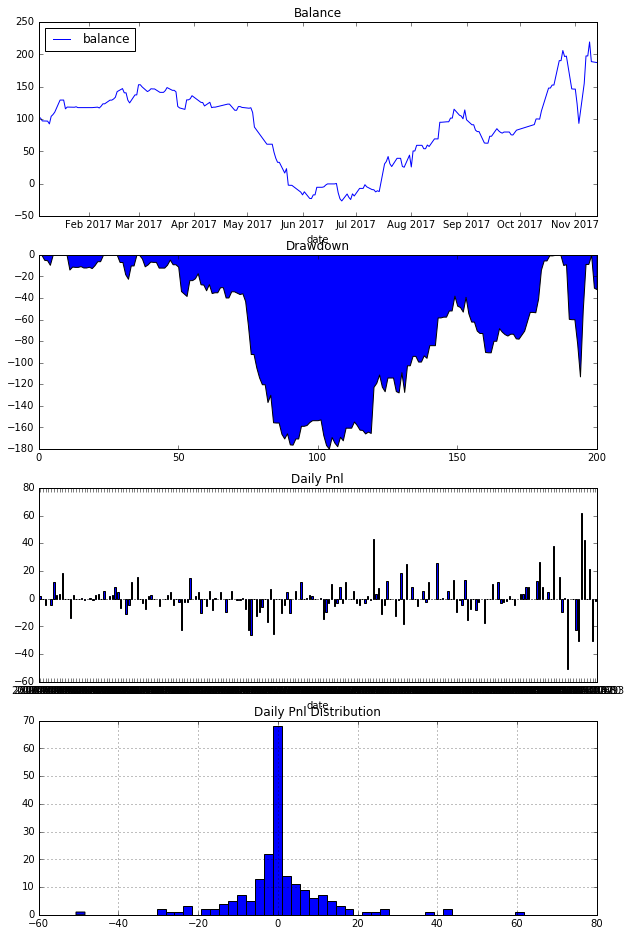

In [9]:
'''
回测
'''
#初始化数据需要的自然日天数
initDays = 3
#初始资金
DualThrustStrategy.capital = 100

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.TICK_MODE)

#设置回测的起始日期
engine.setStartDate('20170101', initDays = initDays) #这里的initDays是真正起作用的

#设置产品相关参数
engine.setSlippage(0)           #滑点设置为0
engine.setRate(1.5/10000)       #股票交易手续费万1.5
engine.setSize(1)               #股票每股为1
engine.setPriceTick(0.01)      #股票最小价格变动
engine.setCapital(DualThrustStrategy.capital) #初始资金

#设置使用的数据库
engine.setDatabase(TICK_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(DualThrustStrategy, {})

#开始跑回测
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()